# Project CIFAR-autoencoder

In this project, we construct a Convolutional Neural Network (CNN)-based autoencoder to encode images from the CIFAR-10 dataset.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import TensorDataset, DataLoader, Subset
import torchvision.transforms as T

import matplotlib.pyplot as plt
import numpy as np


## Import and Process the Data

In [2]:
# Use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# Transformations
transform = T.Compose([T.ToTensor(), T.Normalize([.5,.5,.5],[.5,.5,.5])])

# Import the data simultaniously and apply the transform
trainset = torchvision.datasets.CIFAR10(root='.\data', train=True, download=True, transform=transform)
devtest = torchvision.datasets.CIFAR10(root='.\data', train=False, download=True, transform=transform)

# Split the devset into two seperate sets
randidx = np.random.permutation(10000)
testset = Subset(devtest,randidx)

# Transform to dataloaders
batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True )
test_loader = DataLoader(testset, batch_size=batchsize)

100%|██████████| 170498071/170498071 [00:04<00:00, 41409238.76it/s]


Extracting .\data/cifar-10-python.tar.gz to .\data
Files already downloaded and verified


In [4]:
# Print length of the data
print('data: ')
print(len(trainset.data))
print(len(testset))

# Print the labels and their number
print('\n data labels: ', trainset.classes)
print('data length labels: ', len(trainset.classes))

# Print shape of the data
print('\n data shape: ')
print(trainset.data.shape)

# Print the range of pixel intensity values
print(np.min(trainset.data), np.max(trainset.data))

data: 
50000
10000

 data labels:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
data length labels:  10

 data shape: 
(50000, 32, 32, 3)
0 255


In [5]:
X, y = next(iter(test_loader))
print(torch.min(X), torch.max(X))

print('\nData value shape')
print(X.shape)
print(y.shape)

tensor(-1.) tensor(1.)

Data value shape
torch.Size([32, 3, 32, 32])
torch.Size([32])


## Create the Model

In [6]:
def makeTheNet():
  class encoderNet(nn.Module):
    def __init__(self):
      super().__init__()

      # encoding layer
      self.enc = nn.Sequential(
          nn.Conv2d(3,16,kernel_size=4, padding=1, stride=2),
          nn.ReLU(),
          #nn.MaxPool2d(2,2),
          nn.Conv2d(16,32,kernel_size=4, padding=1, stride=2),
          nn.ReLU(),
          #nn.MaxPool2d(2,2),
          nn.Conv2d(32,64,kernel_size=4, padding=1, stride=2),
          nn.ReLU(),
          #nn.MaxPool2d(2,2)
          )

      # encoding layer
      self.dec = nn.Sequential(
          nn.ConvTranspose2d(64,32, kernel_size=4, padding=1, stride=2),
          nn.ReLU(),
          nn.ConvTranspose2d(32, 16,kernel_size=4, padding=1, stride=2),
          nn.ReLU(),
          nn.ConvTranspose2d(16,3, kernel_size=4, padding=1, stride=2),
      )

    # forward pass
    def forward(self,x):
      x = self.enc(x)
      return self.dec(x)

  # create an instance of the net
  net = encoderNet()

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam( net.parameters(), lr=0.001)

  return net, lossfun, optimizer


### Check if the model is running correct

In [7]:
# Test the model with one batch
net, lossfun, optmizer = makeTheNet()

# Check the size of the output
X, y = next(iter(train_loader))
yHat = net(X)
print(yHat.shape)

# Now compute the loss
loss = lossfun(yHat, X)
print('\nLoss: ',loss.item())

torch.Size([32, 3, 32, 32])

Loss:  0.2930699586868286


## Train the model

In [8]:
def trainTheModel():

  # Number of epochs
  numepochs = 20

  # Create a new model
  net, lossfun, optimizer = makeTheNet()

  # Send the model to the GPU
  net = net.to(device)

  # Initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss = torch.zeros(numepochs)

  for epochi in range(numepochs):

    # Train modus
    net.train()

    # Loop over training data batches
    batchLoss = []

    for X,y in train_loader:

      # Push data to GPU
      X = X.float().to(device)

      # Foward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # Backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Loss fromn this batch
      batchLoss.append(loss.item())
    # End batch loop

    trainLoss[epochi] = np.mean(batchLoss)

    ### Test performance (here done in batches)
    net.eval() # Switch to test mode
    batchLoss = []

    for X,y in test_loader:

      # Push data to GPU
      X = X.float().to(device)

      # Forward pass and loss
      with torch.no_grad():
        yHat = net(X)
        loss = lossfun(yHat,X)
        batchLoss.append(loss.item())
    # End batch loop...

    testLoss[epochi] = np.mean(batchLoss)
  # End epochs

  return trainLoss, testLoss, net, lossfun


## Run the Model

In [9]:
# Run the model
trainLoss, testLoss, net, lossfun = trainTheModel()

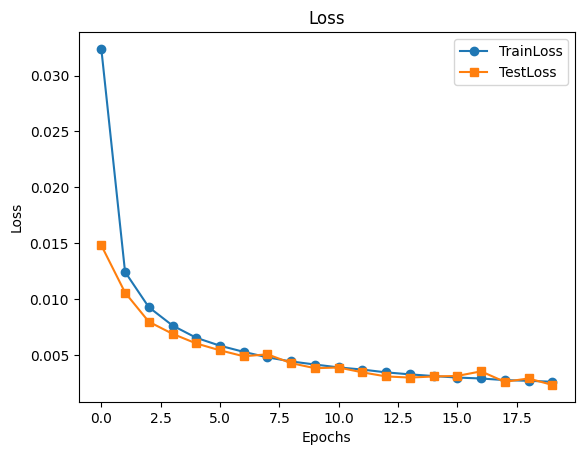

In [10]:
# Plot the trainLosss and test Loss

plt.plot(trainLoss, label='TrainLoss', marker='o')
plt.plot(testLoss, label='TestLoss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

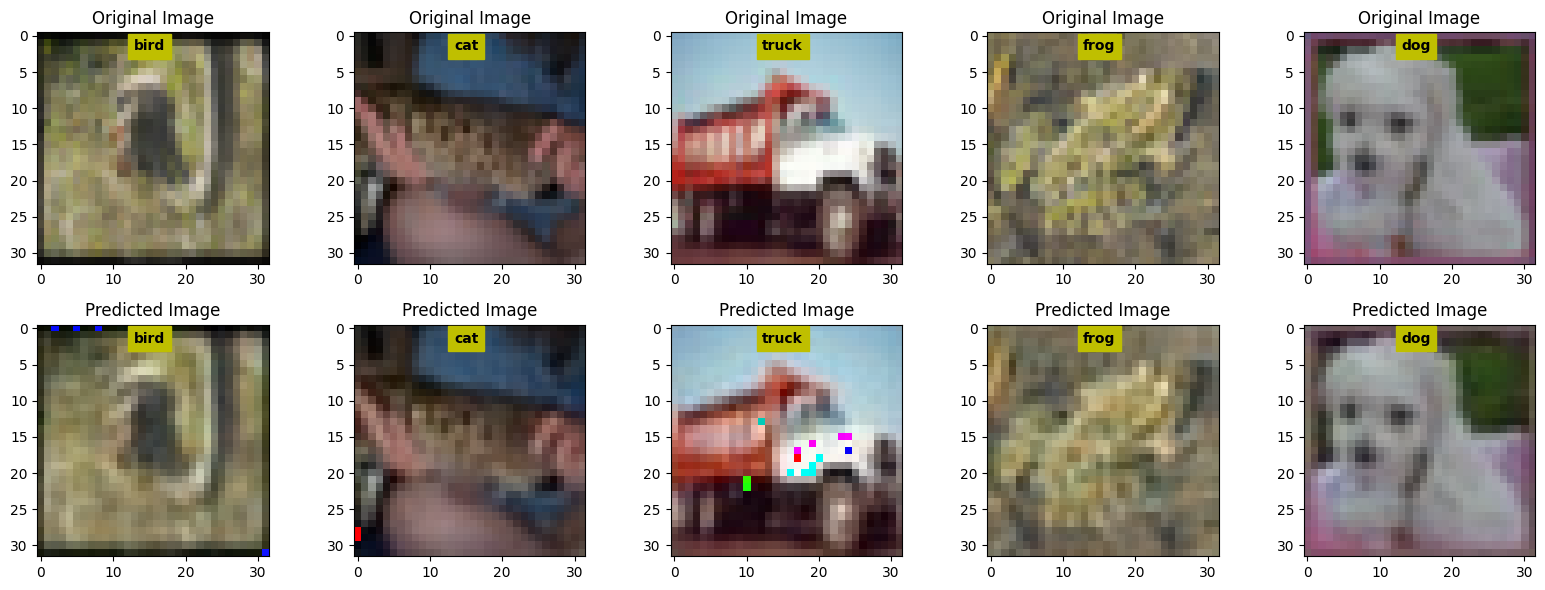

In [13]:
# Get the some images of the test set to make a prediction
X, y = next(iter(test_loader))
yHat = net(X)

# Plot the results
fig, ax = plt.subplots(2,5, figsize=(16,6))

for i in range(0,5):

  # Plot the original image
  groundTruthPic = X[i,:,:,:].numpy().transpose((1,2,0))
  groundTruthPic = groundTruthPic/2 + .5
  ax[0,i].imshow((groundTruthPic* 255).astype(np.uint8))
  ax[0,i].text(15,2, trainset.classes[y[i].item()],ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax[0,i].set_title('Original Image')

  # Plot the predicted image
  predictionPic = yHat[i,:,:,:].detach().numpy().transpose((1,2,0))
  predictionPic = predictionPic/2 + .5
  ax[1,i].imshow((predictionPic* 255).astype(np.uint8))
  ax[1,i].text(15,2,trainset.classes[y[i].item()],ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax[1,i].set_title('Predicted Image')


plt.tight_layout()
plt.show()


## References

https://www.udemy.com/course/deeplearning_x/